In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.join("..", "..", ".."))

from well_logs import Well, WellBatch
from well_logs.batchflow.models.torch import UNet, ResNet18, ResNet34
from well_logs.batchflow import Dataset, FilesIndex, Pipeline, V, B, inbatch_parallel

In [2]:
class LithologyUtils:
    @classmethod
    def get_lithology(self, batch):
        segments = []
        for well in batch.wells:
            segments.extend([segment.core_lithology.FORMATION.values for segment in well.iter_level(level=-1)])
        return segments

    @classmethod
    def get_labels_mapping(self, array, threshold=50):
        array = np.concatenate(array)
        counter = Counter(array)
        name_mapping = {item: item if counter[item] > threshold else 'другое' for item in counter}
        label_mapping = {item: i for i, item in enumerate(np.unique(list(name_mapping.values())))}
        return {item: label_mapping[name_mapping[item]] for item in name_mapping}
    
    @classmethod
    def get_counter(self, array):
        return Counter(np.concatenate(array))
        

In [3]:
well = Well(path='/users/akozhevin/data/server_data/matched_dataset/417по/')

In [4]:
well.create_segments(src=['samples', 'core_lithology'], connected=True)

In [5]:
well

In [6]:
ds = Dataset(index=FilesIndex(path='/users/akozhevin/data/server_data/matched_dataset/*', dirs=True), batch_class=WellBatch)

In [7]:
ppl_template = (Pipeline()
    .add_namespace(LithologyUtils)
    .load()
    .init_variable('lithology', init_on_each_run=list)
    .get_lithology(B(), save_to=V('lithology', mode='e'))
)

In [8]:
ppl_after = (Pipeline()
    .after
    .init_variable('counter')
    .init_variable('mapping')
    .add_namespace(LithologyUtils)
    .get_labels_mapping(V('lithology'), save_to=V('mapping'))
    .get_counter(V('lithology'), save_to=V('counter'))
)

In [9]:
len(ds.indices)

9

In [10]:
ppl = (ppl_template + ppl_after) << ds
ppl.run(9, n_epochs=1, bar=True)

100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


In [11]:
labels_mapping = ppl.v('mapping')

In [12]:
labels_mapping

{'песчаник': 3,
 'алевролит': 0,
 'аргиллит': 1,
 'уголь': 2,
 'глинисто-карбонатная порода': 2,
 'глинисто-кремнистая порода': 2,
 'кремнисто-карбонатная порода': 2}

In [13]:
reverse_mapping = {value: key for key, value in labels_mapping.items()}

In [14]:
len(np.unique(list(labels_mapping.values())))

4

In [15]:
BATCH_SIZE = 1
N_EPOCH = 1
SHAPE = (6, 50, 50)

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': len(np.unique(list(labels_mapping.values()))),
                'initial_block/inputs': 'images',
                'optimizer': 'Adam',
                'output': 'proba',
                'device': 'cpu:0',
                'loss': 'ce'}

load_template = Pipeline().load()

split_template = (Pipeline()
    .create_segments(src=['samples', 'core_lithology'], connected=True)
)

class_template = (Pipeline()
    .add_namespace(np)
    .drop_short_segments(0.1)
    .random_crop(0.1, n_crops=8)
    .get_crops(src=['core_dl', 'core_uv'], dst=['crops_dl', 'crops_uv'])
    .stack(B('crops_uv'), axis=0, save_to=B('crops_uv'))
    .stack(B('crops_dl'), axis=0, save_to=B('crops_dl'))         
    .call(lambda b: np.array([
        labels_mapping[item.core_lithology.FORMATION.values[0]]
        for well in b.wells
        for item in well.iter_level()
    ]), save_to=B('labels'))
    .concatenate((B('crops_dl'), B('crops_uv')), axis=-1, save_to=B('crops'))
    .transpose(B('crops'), axes=(0, 3, 1, 2), save_to=B('crops'))
    .nan_to_num(B('crops'), save_to=B('crops'))
)

train_template = (Pipeline()
    .init_variable('loss', init_on_each_run=list)
    .init_model('dynamic', ResNet34, 'model', model_config)
    .train_model('model', B('crops'), B('labels'), fetches='loss',
                 save_to=V('loss', mode='a'))
)

In [16]:
examples_ppl = (ds.p
    .load()
    .create_segments(src=['samples', 'core_lithology'], connected=True)
    .random_crop(0.1, n_crops=16)
    .call(lambda b: [[item.core_lithology.FORMATION.values for item in well.iter_level()] for well in b.wells], save_to=B('lithology'))
)

In [17]:
train_ppl = (load_template
             + split_template
             + class_template
             + train_template
            ) << ds
train_ppl.run(8, bar=True, n_epochs=10)

100%|██████████| 12/12 [00:55<00:00,  3.81s/it]


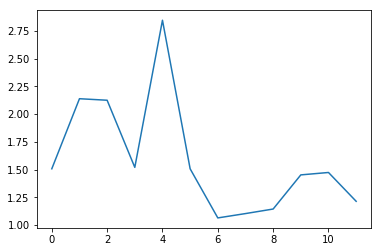

In [18]:
plt.plot(train_ppl.v('loss'))

In [19]:
train_ppl.get_model_by_name('model').save('resnet16_lithology.torch')

with open('loss_lithology', 'wb') as f:
    pickle.dump(train_ppl.get_variable('loss'), f)

with open('dataset_lithology', 'wb') as f:
    pickle.dump(ds, f)

In [22]:
predict_template = (Pipeline()
     .init_variable('proba', init_on_each_run=None)
     .init_variable('metrics', init_on_each_run=None)
     .init_model('dynamic', ResNet34, 'model', config={
                    'device': 'cpu:0', 'load/path': 'resnet16_lithology.torch'
                })
     .predict_model('model', B('crops'), fetches='proba', save_to=B('proba', mode='w'))
     .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                     fmt='proba', axis=-1, save_to=V('metrics', mode='u'))
)

In [23]:
test_ppl = (load_template + split_template + class_template + predict_template) << ds
test_ppl.run(8, bar=True, n_epochs=10, drop_last=False)


  0%|          | 0/12 [00:00<?, ?it/s]

RuntimeError: don't know how to restore data location of torch.FloatStorage (tagged with cpu:0)

In [ ]:
metrics = test_ppl.get_variable('metrics')
print(metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

In [ ]:
labels_mapping